# Stacked Denoising Autoencoders

Inspired and modified from: https://github.com/ageron/handson-ml/blob/master/15_autoencoders.ipynb by Aurélien Géron

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import tensorflow as tf
import sys

from tensorflow.examples.tutorials.mnist import input_data

### To plot pretty figures inline in the notebook

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
print(tf.__version__)
print(np.__version__)
print(matplotlib.__version__)

1.4.0
1.11.1
2.1.0


### Store the MNIST data in "mnist_data/" in the current working directory

In [5]:
mnist = input_data.read_data_sets("mnist_data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist_data/train-images-idx3-ubyte.gz


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist_data/train-labels-idx1-ubyte.gz


Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist_data/t10k-images-idx3-ubyte.gz


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


### Result the default graph so you can have a fresh run

In [6]:
tf.reset_default_graph()

### Displays a digit inline on screen
* Takes in a 1-D array of 784 pixels representing an image

In [7]:
def display_digit(digit):
    plt.imshow(digit.reshape(28, 28), cmap="Greys", interpolation='nearest')

### Pass in 2 test images and see how they are reconstructed using the Autoencoder

* Reconstructs the session using the saved model
* Sets up the plot to display the original and reconstructed image side-by-side

In [8]:
def show_reconstructed_digits(X, outputs, model_path = None, num_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[10 : 10 + num_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * num_digits))
    for i in range(num_digits):
        plt.subplot(num_digits, 2, i * 2 + 1)
        display_digit(X_test[i])
        plt.subplot(num_digits, 2, i * 2 + 2)
        display_digit(outputs_val[i])

### Build a stacked denoising autoencoder with 3 hidden layers
   * Number of inputs are 28 * 28 = 784, the number of pixels in any MNIST image
   * The hidden layers are symmetric and get progressively narrower
   * The narrowest layer is the codings
   * The number of inputs is equal to the number of outputs 

In [9]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

### Use Gaussian noise

Some noise is added to every input image

In [10]:
# Change this noise level to 0.5 and see that it performs better
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

### Set up layers of the Autoencoder neural network

* We use a partial specification for tf.layers.dense to make it easier to read the code
* We use the RELU activation function
* The last layer does not have an activation function

In [11]:
from functools import partial

dense_layer = partial(tf.layers.dense,
                      activation=tf.nn.relu)

hidden1 = dense_layer(X_noisy, n_hidden1)
hidden2 = dense_layer(hidden1, n_hidden2)
hidden3 = dense_layer(hidden2, n_hidden3)
outputs = dense_layer(hidden3, n_outputs, activation=None)

### Set up the loss function and the optimizer

In [12]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(0.01)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() 

### Train the model using training data

* Note that we do not use the labels from each MNIST batch
* At the end of each epoch write the model out to a checkpoint

In [14]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size

        for iteration in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})

        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   
        print("\r{}".format(epoch), "Train MSE:", loss_train)

        saver.save(sess, "./stacked_denoising_gaussian_autoencoder.ckpt")

INFO:tensorflow:Restoring parameters from ./stacked_denoising_gaussian_autoencoder.ckpt


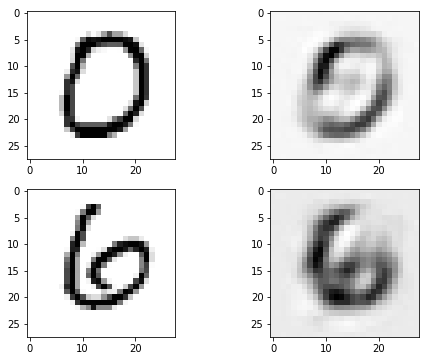

In [15]:
# Noise level 1.0
show_reconstructed_digits(X, outputs, "./stacked_denoising_gaussian_autoencoder.ckpt")

INFO:tensorflow:Restoring parameters from ./stacked_denoising_gaussian_autoencoder.ckpt


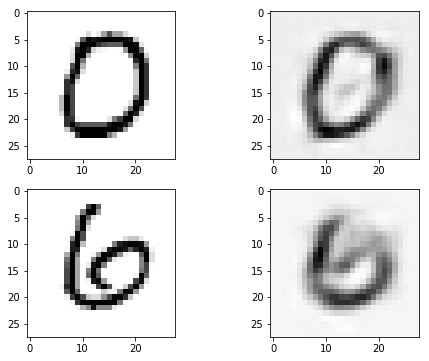

In [21]:
# Noise level 0.5
show_reconstructed_digits(X, outputs, "./stacked_denoising_gaussian_autoencoder.ckpt")